In [1]:
import numpy as np
from glob import glob
import os
import gc
from pathlib import Path
import yaml

from matplotlib import pyplot as plt
from cycler import cycler
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.backends.backend_pdf import PdfPages
plt.style.use('thesis')

from scipy.optimize import curve_fit
import scipy.signal as sig
from scipy import stats

plt.rcParams.update({'figure.dpi': 150})
plt.rcParams.update({'axes.prop_cycle': cycler(color=['#5994cd', '#d74164', '#4eaa76', '#d88300', '#7365cf', \
                                                      '#c85e3e', '#83a23e', '#c851b1', '#1850a1'])})

from importlib import reload
import data_processing as dp

### Look through the drive/data directory and print folder structure

In [2]:
data_path = '/Users/clarke/Documents/Research/Nanospheres/Data/'
# base_path = '/Volumes/LaCie/gas_collisions/pulse_calibration/sphere_20251212/' #0908/'
base_path = '/Users/clarke/Data/gas_collisions/pulse_calibration/sphere_20251212/' #sphere_20251212/'#sphere_20251129/' #sphere_20250908/'
# drive_path = '/Volumes/LaCie/'
drive_path = '/Users/clarke/Data/'
# base_path = '/Volumes/LaCie/pulse_calibration/sphere_20250406/'

if not os.path.exists(drive_path):
    print('Error: check that the external drive is plugged in!')

folders = glob(base_path + '*')

datasets = {}

for folder in folders:
    print(folder.split(base_path)[-1])
    all_items = glob(folder + '/*.hdf5')
    subfolders = np.unique(['_'.join(s.split('_')[:-1]) for s in all_items])
    sub_datasets = []
    for subfolder in subfolders:
        sub_datasets.append(subfolder.split(base_path)[-1].split('/')[-1])
        print('\t' + subfolder.split(base_path)[-1].split('/')[-1])
    datasets[folder.split(base_path)[-1]] = sub_datasets

20251215_electric_calibration_5e-8mbar_0
	20251215_d_p8e_117khz_0.5vpp_lensholder1
	20251215_d_p8e_117khz_1.5vpp_lensholder1
	20251215_d_p8e_117khz_1vpp_lensholder1
	20251215_d_p8e_117khz_2vpp_lensholder1
	20251215_d_p8e_nodrive
20251215_p4e_5e-8mbar_d137khz_1
	20251215_dfg_p4e_200ns_10v
	20251215_dfg_p4e_200ns_12.5v
	20251215_dfg_p4e_200ns_15v
	20251215_dfg_p4e_200ns_17.5v
	20251215_dfg_p4e_200ns_2.5v
	20251215_dfg_p4e_200ns_20v
	20251215_dfg_p4e_200ns_5v
	20251215_dfg_p4e_200ns_7.5v
20251215_p4e_5e-8mbar_d137khz_0
	20251215_dfg_p4e_200ns_10v
	20251215_dfg_p4e_200ns_12.5v
	20251215_dfg_p4e_200ns_15v
	20251215_dfg_p4e_200ns_17.5v
	20251215_dfg_p4e_200ns_2.5v
	20251215_dfg_p4e_200ns_20v
	20251215_dfg_p4e_200ns_5v
	20251215_dfg_p4e_200ns_7.5v
20251215_p8e_5e-8mbar_d137khz_0
	20251215_dfg_p8e_200ns_10v
	20251215_dfg_p8e_200ns_12.5v
	20251215_dfg_p8e_200ns_15v
	20251215_dfg_p8e_200ns_17.5v
	20251215_dfg_p8e_200ns_2.5v
	20251215_dfg_p8e_200ns_20v
	20251215_dfg_p8e_200ns_5v
	20251215_dfg_p8e

### Specify impulse and analysis parameters

In [40]:
pulse_amps_1e = np.asarray([12, 34, 57, 80, 103, 127, 150, 174]) # impulses applied to the particle in eV/c
pulse_amps_V = np.arange(2.5, 21, 2.5) # pulse amplitudes applied to lens holder 1 in V

# t_window = 2e-3 # the window length in ms
search_window = 5e-5
fit_window = 1e-1 # time window for resonance fits
f_cutoff_high = 1e5 # upper cutoff frequency for the bandpass filter
f_cutoff_low = 2.5e4 # lower cutoff frequency for the bandpass filter
f_cutoff = [f_cutoff_low, f_cutoff_high]

config = {
    'fit_window': fit_window,
    'search_window': search_window,
    'meters_per_volt': None,
    'f_cutoff': f_cutoff,
    'apply_notch': False,
    'calibrate': True
}

### Load and process the data

In [43]:
reload(dp)

# choose which dataset to look at
dataset_ind = 3
dataset = list(datasets.keys())[dataset_ind]

# get the list of impulse amplitudes in that dataset
amp_list = np.argsort([float(d.split('v')[0].split('_')[-1]) for d in datasets[dataset]])
amp_list = np.concat(([amp_list[0]], amp_list))

pulse_amps_keV = []
impulses = []
resonance_params = []
pulses = []
recon_inds = []
timestamps = []
pulse_times = []
meters_per_volt = []

# number of files to look at for each amplitude
max_files = 2

# when plotting, only look at one file
plot = False
if plot:
    max_files = 1

# loop through all four files in that dataset in the correct order
for i, file_ind in enumerate(amp_list):
    if i == 0 and plot:
        continue
    filename = datasets[list(datasets.keys())[dataset_ind]][file_ind]
    plot_path = 'figures/' + base_path.split(drive_path)[-1] + dataset + '/' + filename \
                if plot else None
    nd = dp.NanoDataset(base_path + dataset + '/' + filename, plot_path, verbose=True, max_files=max_files, config=config)
    nd.load_calibration_data(global_params=False, pulse_amps_1e=pulse_amps_1e, pulse_amps_V=pulse_amps_V, noise=i==0)
    impulses.append(nd.impulses.copy())
    pulse_amps_keV.append([nd.pulse_amp_keV.copy(), 0][i==0])
    resonance_params.append(nd.resonance_params.copy())
    pulses.append(nd.pulses.copy())
    recon_inds.append(nd.recon_impulse_inds.copy())
    pulse_times.append(nd.pulse_times.copy())
    timestamps.append(nd.timestamps.copy())
    meters_per_volt.append(nd.meters_per_volt.copy())

    if i == 0:
        freqs = np.copy(nd.freqs)
    del nd
    
    # if plot and i > 0:
    #     break

pulse_amps_keV = np.array(pulse_amps_keV)
min_len = np.amin([len(l) for l in impulses])
impulses = np.array([l[:min_len] for l in impulses])
pulses = np.array([l[:min_len] for l in pulses])
recon_inds = np.array([l[:min_len] for l in recon_inds])
resonance_params = np.array([l[:min_len] for l in resonance_params])
pulse_times = np.array([l[:min_len] for l in pulse_times])
timestamps = np.array([l[:min_len] for l in timestamps])
meters_per_volt = np.mean(meters_per_volt)

Loading files starting with
/Users/clarke/Data/gas_collisions/pulse_calibration/sphere_20251212/20251215_p8e_5e-8mbar_d137khz_0/20251215_dfg_p8e_200ns_2.5v
  Loading file 1...
  Calibrating volts to meters...
    Mass of the nanosphere: 		6.347e-18 kg
    Number of charges on the sphere: 	8
    Electric field per volt applied: 	79.0 V/m
    Trap resonant frequency: 		48.2 kHz
    Drive signal from demodulation: 	0.505 V
    Applied force from demodulation: 	5.110e-17 N
    Sensor response from demodulation: 	2.359e-04 V
    Susceptibility at 137.0 kHz drive: 	2.427e+05 m/V
    Nanosphere response amplitude: 	1.240e-11 m
    Position calibration factor: 	5.274e-08 m/V
    -> Computing impulse for kick at t=0.04477 seconds...
    -> Computing impulse for kick at t=0.34476 seconds...
    -> Computing impulse for kick at t=0.64476 seconds...
    -> Computing impulse for kick at t=0.94475 seconds...
    -> Computing impulse for kick at t=1.24475 seconds...
    -> Computing impulse for kick 

### Monitor drifts in the resonance over time

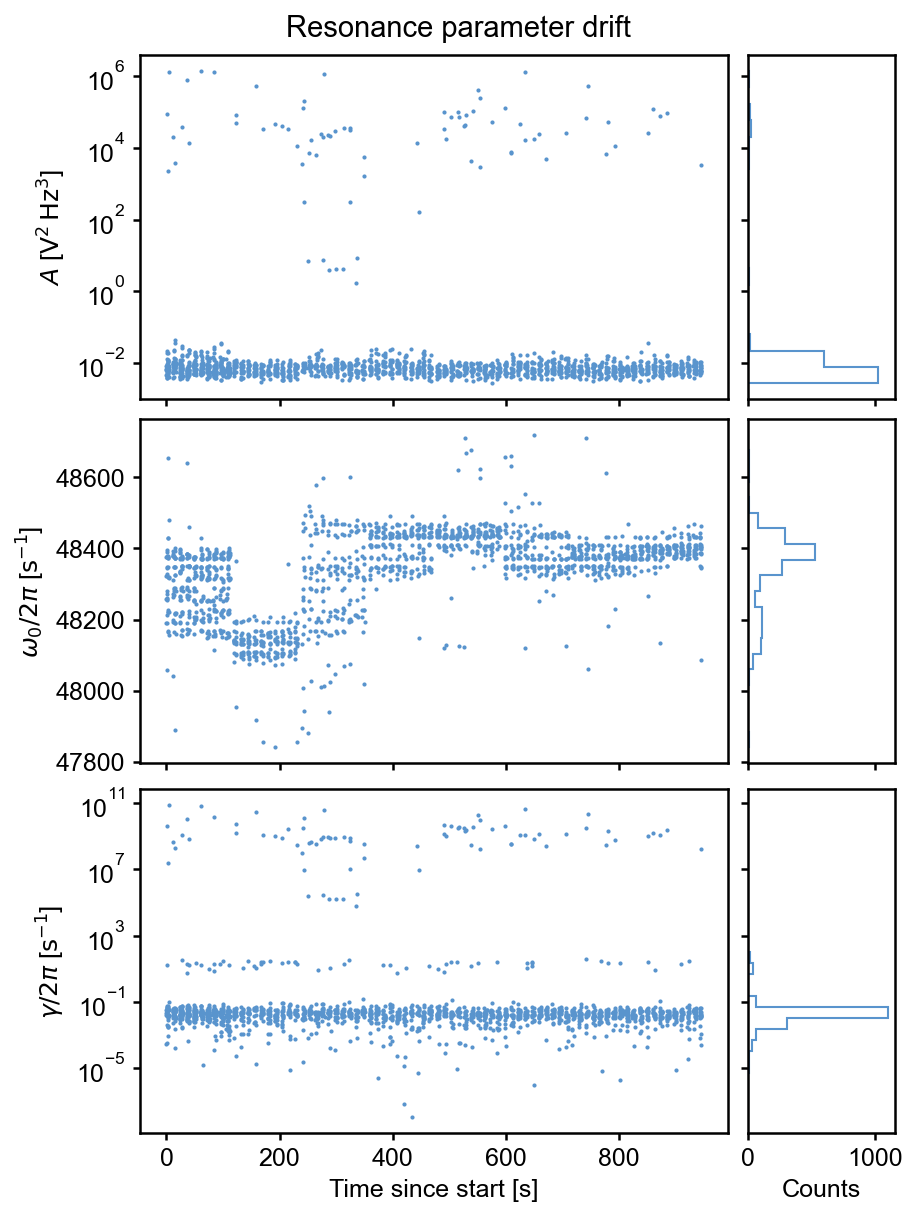

In [5]:
n_repeats = (pulse_times.shape[1] + timestamps.shape[1] - 1) // timestamps.shape[1]
pulse_timestamps = pulse_times + np.tile(timestamps, (1, n_repeats))[:, :pulse_times.shape[1]]
res_evol = np.array([resonance_params[...,i].flatten()[np.argsort(pulse_timestamps.flatten())] for i in range(3)])
res_times = np.sort(pulse_timestamps.flatten()) - np.amin(pulse_timestamps)

fig, ax = plt.subplots(3, 2, figsize=(6, 8), sharex='col', sharey='row', width_ratios=[4, 1], layout='constrained')
ax[0,0].semilogy(res_times, res_evol[0], marker='.', ms=2, ls='none')
ax[0,1].hist(res_evol[0], bins=np.logspace(np.log10(np.amin(res_evol[0])), \
             np.log10(np.amax(res_evol[0])), 20), histtype='step', orientation='horizontal')
ax[1,0].plot(res_times, res_evol[1]/2/np.pi, marker='.', ms=2, ls='none')
ax[1,1].hist(res_evol[1]/2/np.pi, bins=20, histtype='step', orientation='horizontal')
ax[2,0].semilogy(res_times, res_evol[2]/2/np.pi, marker='.', ms=2, ls='none')
ax[2,1].hist(res_evol[2]/2/np.pi, bins=np.logspace(np.log10(np.amin(res_evol[2]/2/np.pi)), \
             np.log10(np.amax(res_evol[:,2]/2/np.pi)), 20), \
             histtype='step', orientation='horizontal')
ax[0,0].set_ylabel(r'$A$ [$\mathrm{V^2\,Hz^3}$]')
ax[1,0].set_ylabel(r'$\omega_0/2\pi$ [$\mathrm{s}^{-1}$]')
ax[2,0].set_ylabel(r'$\gamma/2\pi$ [$\mathrm{s}^{-1}$]')
ax[2,0].set_xlabel('Time since start [s]')
ax[2,1].set_xlabel('Counts')
fig.suptitle('Resonance parameter drift')
if plot_path:
    fig.savefig(plot_path + '_res_evol.pdf')

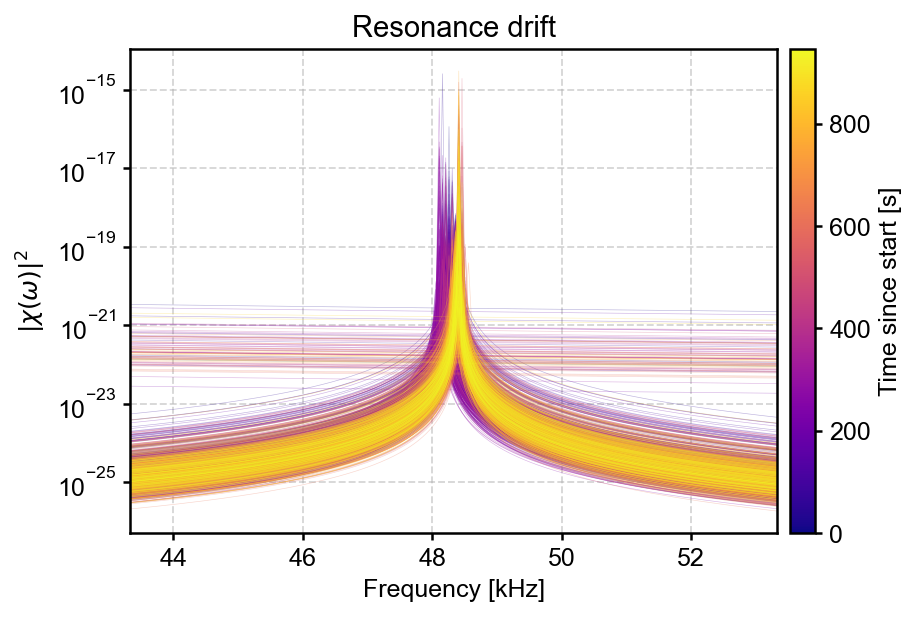

In [6]:
fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')

freq_range = np.mean(res_evol[1])/2/np.pi/1e3 + np.array((-5, 5))

omegas = 2*np.pi*1e3*np.linspace(np.amin(freq_range), np.amax(freq_range), 200)
colors = [plt.get_cmap('plasma', res_evol.shape[1])(i) for i in range(res_evol.shape[1])]

for i, params in enumerate(res_evol.T):
    ax.plot(1e-3*omegas/2/np.pi, dp.abs_susc2(omegas, *params), alpha=0.3, lw=0.3, color=colors[i])

ax.set_yscale('log')
ax.set_xlabel('Frequency [kHz]')
ax.set_xlim(freq_range)
ax.set_ylabel(r'$|\chi(\omega)|^2$')
ax.set_title('Resonance drift')
ax.grid()
fig.colorbar(ScalarMappable(norm=Normalize(0, np.amax(res_times)), cmap='plasma'), ax=ax, label='Time since start [s]', pad=0.02)
if plot_path:
    fig.savefig(plot_path + '_res_drift.pdf')

### Look at the average waveform for each impulse magnitude

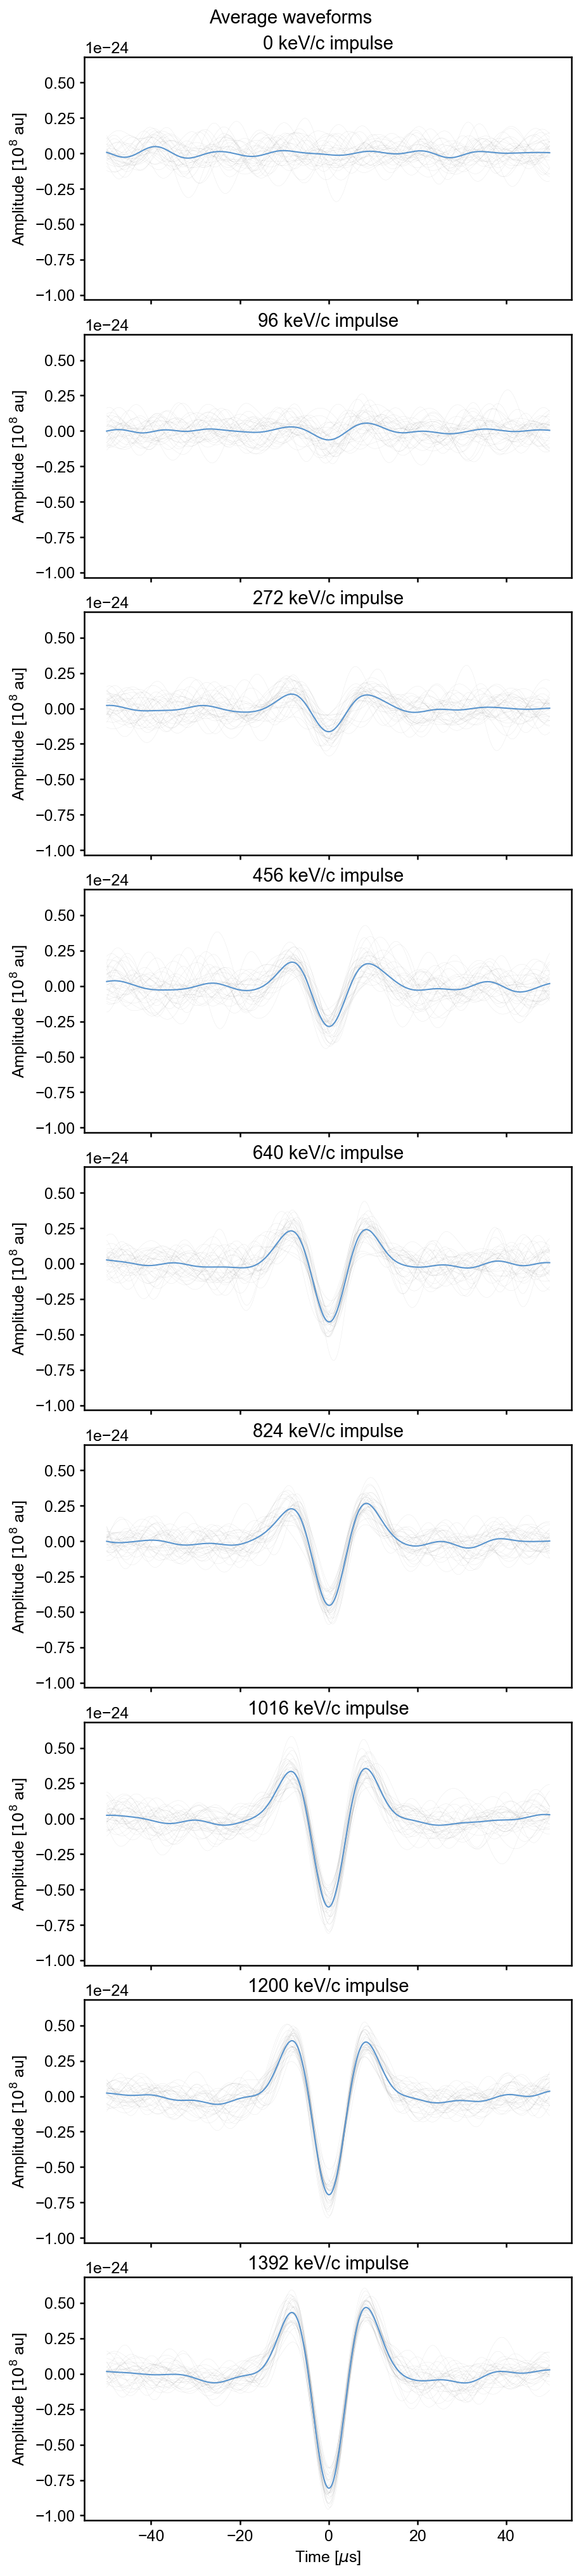

In [54]:
# build a time array
half_window = 250
peak_ind = np.argmax(np.abs(np.mean(pulses[-1], axis=0)))
times = np.arange(0, pulses.shape[-1]/2./freqs[-1], 1./2./freqs[-1])
times -= times[peak_ind]
time_slice = times[..., peak_ind - half_window:peak_ind + half_window]

# get the cropped waveforms centered around the true impulse time
pulses_true_imp = pulses[..., peak_ind - half_window:peak_ind + half_window]
mean_pulses_true_imp = np.mean(pulses_true_imp, axis=1)

# get the cropped waveforms centered around the reconstructed impulse time
offsets = np.arange(2*half_window) - half_window
time_inds = recon_inds[..., None] + offsets
pulses_recon_imp = np.take_along_axis(pulses, time_inds, axis=2)
mean_pulses_recon_imp = np.mean(pulses_recon_imp, axis=1)

fig, ax = plt.subplots(mean_pulses_true_imp.shape[0], figsize=(6, 3*mean_pulses_true_imp.shape[0]), \
                       sharex=True, sharey=True, layout='constrained')
for i in range(mean_pulses_true_imp.shape[0]):
    ax[i].plot(time_slice*1e6, pulses_true_imp[i].T*1e-8, lw=0.2, alpha=0.1, color='k')
    ax[i].plot(time_slice*1e6, mean_pulses_true_imp[i]*1e-8)
    ax[i].set_ylabel('Amplitude [$10^8$ au]')
    ax[i].set_title('{:.0f} keV/c impulse'.format(pulse_amps_keV[i]))
ax[-1].set_xlabel(r'Time [$\mu$s]')
fig.suptitle('Average waveforms')
if plot_path:
    fig.savefig(plot_path + 'avg_wfms_uncal.pdf')

### Calibrate to the known impulses

0 keV/c impulse:	 63.1 keV resolution
96 keV/c impulse:	 69.1 keV resolution
272 keV/c impulse:	 75.2 keV resolution
456 keV/c impulse:	 120.0 keV resolution
640 keV/c impulse:	 130.9 keV resolution
824 keV/c impulse:	 117.6 keV resolution
1016 keV/c impulse:	 143.6 keV resolution
1200 keV/c impulse:	 136.4 keV resolution
1392 keV/c impulse:	 136.9 keV resolution
----------------------------------------------
Mean resolution:	 122.9 keV


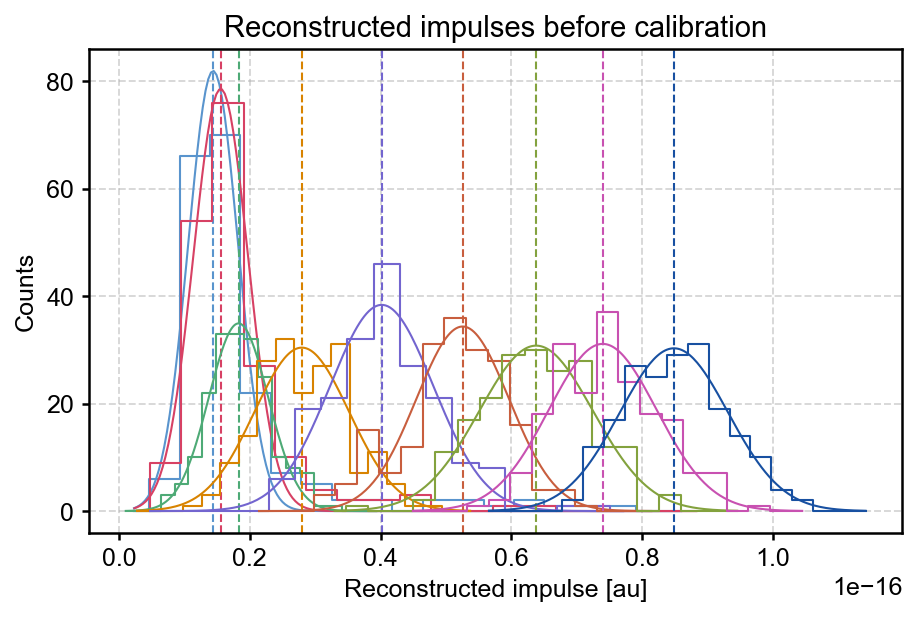

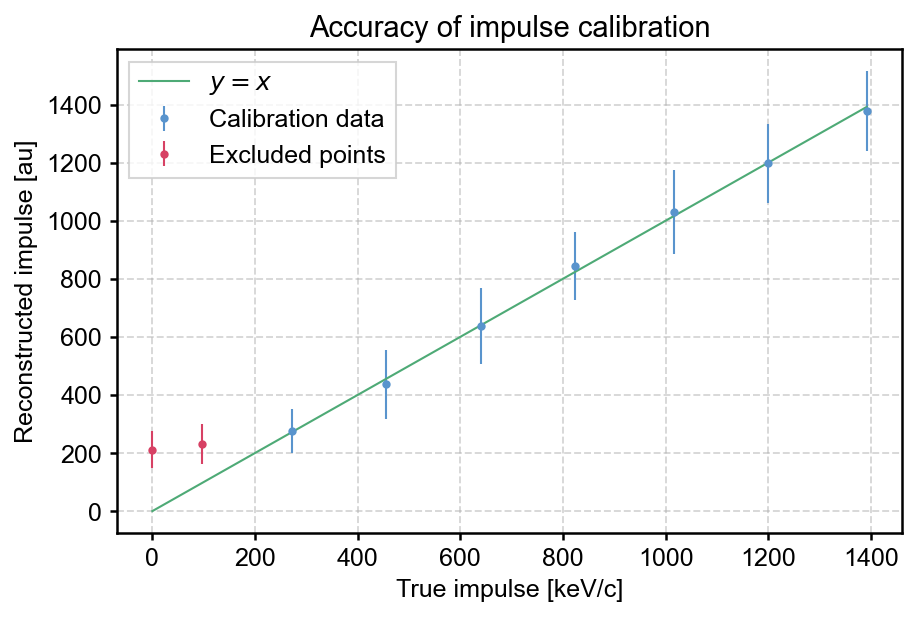

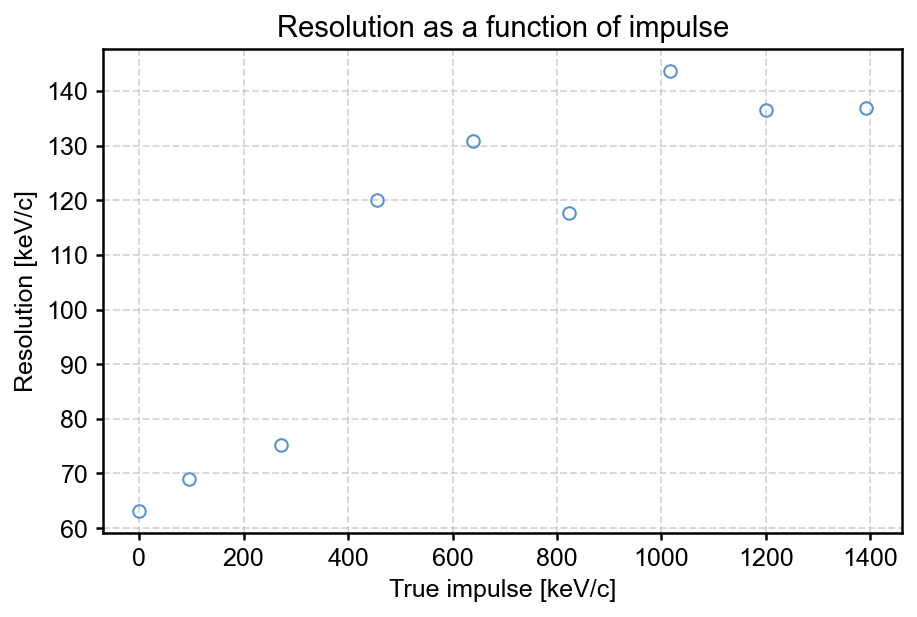

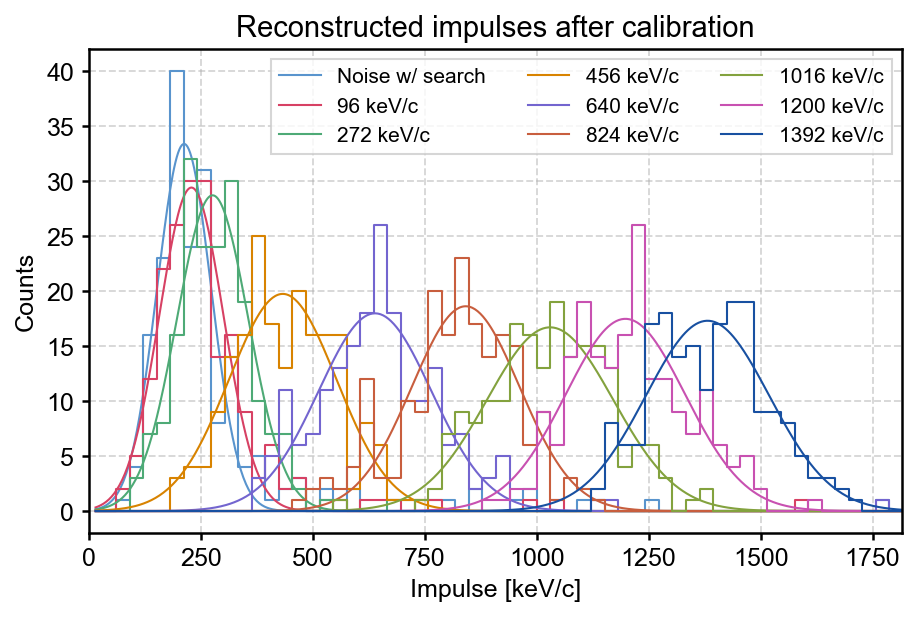

In [33]:
def gaus(x, A, mu, sigma):
    return A*np.exp(-(x - mu)**2/2/sigma**2)

def linear(x, m, b):
    return m*x + b

def to_keV(x, m, b):
    return (x - b)/m

means = []
errs = []

fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
for i, imp in enumerate(impulses):
    mean = np.mean(np.abs(imp))
    std = np.std(np.abs(imp))
    counts, bins = np.histogram(np.abs(imp), bins=np.linspace(np.amax((0, mean - 4*std)), mean + 4*std, 20))
    bins = (bins[:-1] + bins[1:])/2.
    p, _ = curve_fit(gaus, bins, counts, p0=(10, np.mean(np.abs(imp)), np.std(np.abs(imp))))
    plot_bins = np.linspace(bins[0], bins[-1], 200)
    ax.step(bins, counts, color='C' + str(i), where='mid')
    ax.plot(plot_bins, gaus(plot_bins, *p), color='C' + str(i))
    means.append(p[1])
    errs.append(np.abs(p[2]))
    ax.axvline(p[1], ls='--', color='C' + str(i))
ax.set_xlabel('Reconstructed impulse [au]')
ax.set_ylabel('Counts')
# ax.set_xlim([0, 250])
ax.set_title('Reconstructed impulses before calibration')
ax.grid()
if plot_path:
    fig.savefig(plot_path + '_recon_uncal.pdf')

means = np.array(means)
errs = np.array(errs)

exclude_first = 2 # how many of the first datasets to exclude from the calibration line fit

fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
plot_amps = np.linspace(0, np.amax(pulse_amps_keV), 2)
cal_params, _ = curve_fit(linear, pulse_amps_keV[exclude_first:], means[exclude_first:])
ax.errorbar(pulse_amps_keV[exclude_first:], to_keV(means[exclude_first:], *cal_params), \
            to_keV(errs[exclude_first:], cal_params[0], 0), marker='.', ls='none', label='Calibration data')
ax.errorbar(pulse_amps_keV[:exclude_first], to_keV(means[:exclude_first], *cal_params), \
            to_keV(errs[:exclude_first], cal_params[0], 0), marker='.', ls='none', label='Excluded points')
ax.plot(plot_amps, plot_amps, label='$y=x$')
# ax.text(0.95, 0.05, '${}x+{}$'.format(*cal_params), ha='right', va='bottom', transform=ax.transAxes)
ax.set_xlabel('True impulse [keV/c]')
ax.set_ylabel('Reconstructed impulse [au]')
ax.set_title('Accuracy of impulse calibration')
ax.legend()
ax.grid()
if plot_path:
    fig.savefig(plot_path + '_calibration.pdf')

fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
ax.plot(pulse_amps_keV, to_keV(errs, cal_params[0], 0), marker='o', ls='none', fillstyle='none')
ax.set_xlabel('True impulse [keV/c]')
ax.set_ylabel('Resolution [keV/c]')
ax.set_title('Resolution as a function of impulse')
ax.grid()
if plot_path:
    fig.savefig(plot_path + '_resolution.pdf')

fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
for i, imp in enumerate(impulses):
    if i == 0:
        label = 'Noise w/ search'
    else:
        label = '{:.0f} keV/c'.format(pulse_amps_keV[i])
    imp_cal = np.abs(imp)/cal_params[0] - cal_params[1]/cal_params[0]
    counts, bins = np.histogram(imp_cal, bins=np.linspace(0, 3000, 100))
    bins = (bins[:-1] + bins[1:])/2.
    p0 = (100, np.mean(imp_cal), np.std(imp_cal))
    try:
        p, _ = curve_fit(gaus, bins, counts, p0=p0)
    except RuntimeError:
        p = p0
    plot_bins = np.linspace(bins[0], bins[-1], 1000)
    ax.step(bins, counts, color='C' + str(i), where='mid')
    ax.plot(plot_bins, gaus(plot_bins, *p), color='C' + str(i), label=label)
ax.set_xlim([0, means[-1]/cal_params[0] + 3*errs[-1]/cal_params[0]])
ax.set_xlabel('Impulse [keV/c]')
ax.set_ylabel('Counts')
ax.grid()
ax.legend(ncol=len(impulses)//3, fontsize=10)
ax.set_title('Reconstructed impulses after calibration')
if plot_path:
    fig.savefig(plot_path + '_recon_cal.pdf')

resolutions = errs/cal_params[0]
for pulse, res in zip(pulse_amps_keV, resolutions):
    print('{:.0f} keV/c impulse:\t {:.1f} keV resolution'.format(pulse, res))

print('----------------------------------------------')
print('Mean resolution:\t {:.1f} keV'.format(np.mean(resolutions[2:])))

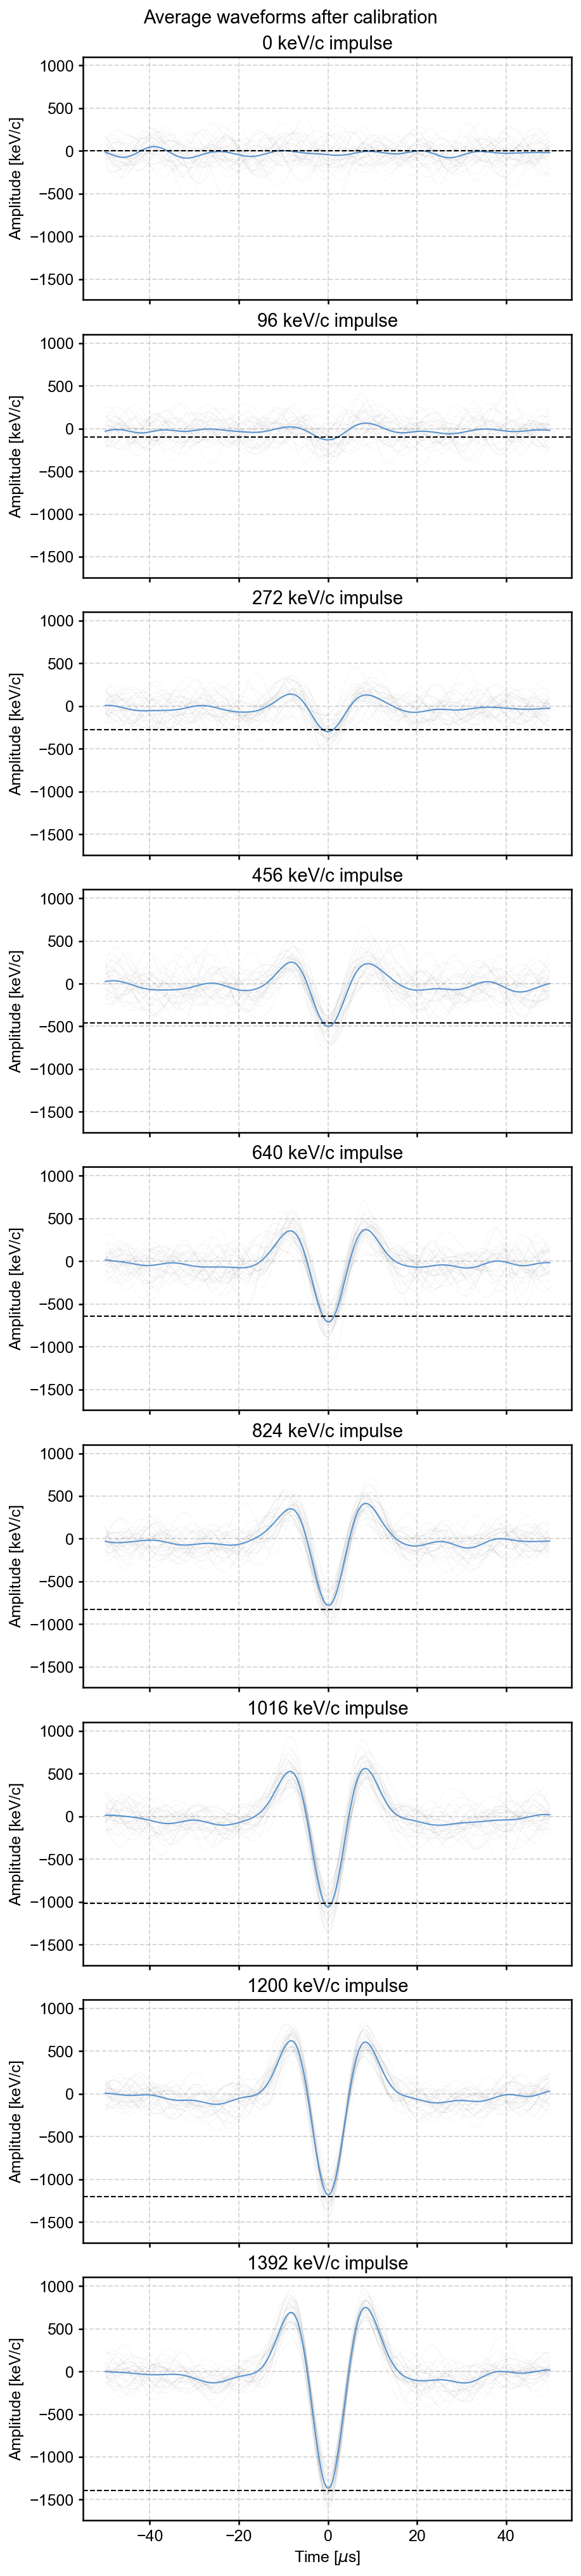

In [55]:
fig, ax = plt.subplots(mean_pulses_true_imp.shape[0], figsize=(6, 3*mean_pulses_true_imp.shape[0]), \
                       sharex=True, sharey=True, layout='constrained')
for i in range(mean_pulses_true_imp.shape[0]):
    ax[i].plot(time_slice*1e6, to_keV(pulses_true_imp[i].T, *cal_params), lw=0.2, alpha=0.1, color='k')
    ax[i].plot(time_slice*1e6, to_keV(mean_pulses_true_imp[i], *cal_params))
    ax[i].axhline(-pulse_amps_keV[i], color='k', ls='--')
    ax[i].set_ylabel('Amplitude [keV/c]')
    ax[i].set_title('{:.0f} keV/c impulse'.format(pulse_amps_keV[i]))
    ax[i].grid(which='both')
ax[-1].set_xlabel(r'Time [$\mu$s]')
fig.suptitle('Average waveforms after calibration')
if plot_path:
    fig.savefig(plot_path + 'avg_wfms_cal.pdf')

### See how pulse shape changes with amplitude
It appears that the pulse shapes are the same up to a scaling factor. To get the best SNR, use the largest calibration pulse as the template. Note that this is only true when the *true* pulse location is used. When the inferred location is used, errors in identifying the impulse time in an individual waveform causes smearing of the average waveforms.

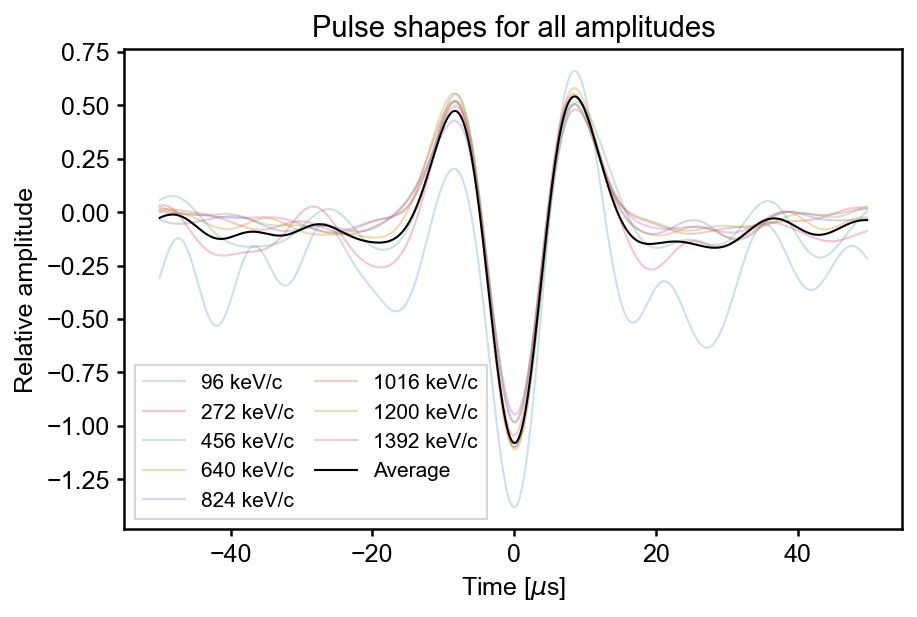

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
for i, mp in enumerate(mean_pulses_true_imp):
    if i == 0:
        continue
    ax.plot(time_slice*1e6, to_keV(mp, *cal_params)/pulse_amps_keV[i], alpha=0.3, label='{:.0f} keV/c'.format(pulse_amps_keV[i]))
ax.plot(time_slice*1e6, np.mean(to_keV(mean_pulses_true_imp[1:], *cal_params)/pulse_amps_keV[1:, None], axis=0), color='k', label='Average')
ax.set_xlabel(r'Time [$\mu$s]')
ax.set_ylabel('Relative amplitude')
ax.set_title('Pulse shapes for all amplitudes')
ax.legend(ncol=len(pulse_amps_keV)//4, columnspacing=1., fontsize=10)

pulse_1_keV = -to_keV(mean_pulses_true_imp[-1], *cal_params)/pulse_amps_keV[-1]

### Add the calibration parameters to the config file

In [58]:
config['cal_factors'] = [float(1/cal_params[0]), float(-cal_params[1]/cal_params[0])]
config['template'] = [float(i) for i in pulse_1_keV]
config['resolution'] = float(np.sqrt(np.mean(resolutions[2:]**2)))
config['meters_per_volt'] = float(meters_per_volt)

with open(base_path + dataset + '/config.yaml', 'w') as f:
    yaml.safe_dump(config, f)